<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter18/building_a_panoramic_view_of_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_snippets
from torch_snippets import *
# feature_extractor = 'orb' 
# feature_matching = 'bf'

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 36.7MB 1.3MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=f8a165c3ac2b22ad80f61738b271ef93036c96cd11af1335186f06598bb97516
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars


In [2]:
!wget https://www.dropbox.com/s/mfg1codtc2rue84/g1.png
!wget https://www.dropbox.com/s/4yhui8s1xjndavm/g2.png

--2020-10-05 17:11:49--  https://www.dropbox.com/s/mfg1codtc2rue84/g1.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mfg1codtc2rue84/g1.png [following]
--2020-10-05 17:11:49--  https://www.dropbox.com/s/raw/mfg1codtc2rue84/g1.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5ae3b5e6d89a5d1f941a070eb5.dl.dropboxusercontent.com/cd/0/inline/BAtSVe1XsaaYz-dNUT8PucSdjy59J17P0-IX4lxNRncoz7CpXaFnCeJ_3ClhJ_xqjSaE8G_HWaraS8s184p7sjLBHHXf1_83whtDGgIVRo2edKrdQAlEKy5qjMY03HJmeZU/file# [following]
--2020-10-05 17:11:49--  https://uc5ae3b5e6d89a5d1f941a070eb5.dl.dropboxusercontent.com/cd/0/inline/BAtSVe1XsaaYz-dNUT8PucSdjy59J17P0-IX4lxNRncoz7CpXaFnCeJ_3ClhJ_xqjSaE8G_HWaraS8s184p7sjLBHHXf1_83whtDGgIVRo2edKrdQAlEKy5qjMY03HJmeZU/

2020-10-05 17:11:53.215 | INFO     | torch_snippets.loader:subplots:339 - plotting 2 images in a grid of 1x2 @ (10, 5)


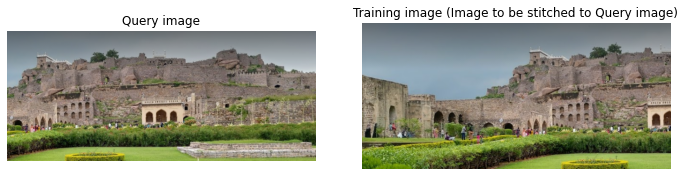

In [3]:
queryImg = read('g1.png', 1)
queryImg_gray = read('g1.png')

trainImg = read('g2.png', 1)
trainImg_gray = read('g2.png')


subplots([trainImg, queryImg], nc=2, figsize=(10,5), titles = ['Query image','Training image (Image to be stitched to Query image)'])

2020-10-05 17:11:53.638 | INFO     | torch_snippets.loader:subplots:339 - plotting 2 images in a grid of 1x2 @ (10, 5)


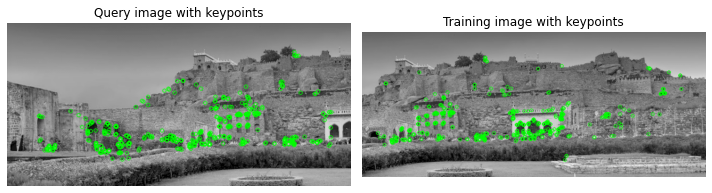

In [4]:
# Fetch the keypoints and features corresponding to the images
descriptor = cv2.ORB_create()
kpsA, featuresA = descriptor.detectAndCompute(trainImg_gray, None)
kpsB, featuresB = descriptor.detectAndCompute(queryImg_gray, None)

# Draw the keypoints obtained on images
img_kpsA = cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0))
img_kpsB = cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0))
subplots([img_kpsB, img_kpsA], nc=2, figsize=(10,5), titles=['Query image with keypoints','Training image with keypoints'])

In [5]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
best_matches = bf.match(featuresA,featuresB)
matches = sorted(best_matches, key = lambda x:x.distance)

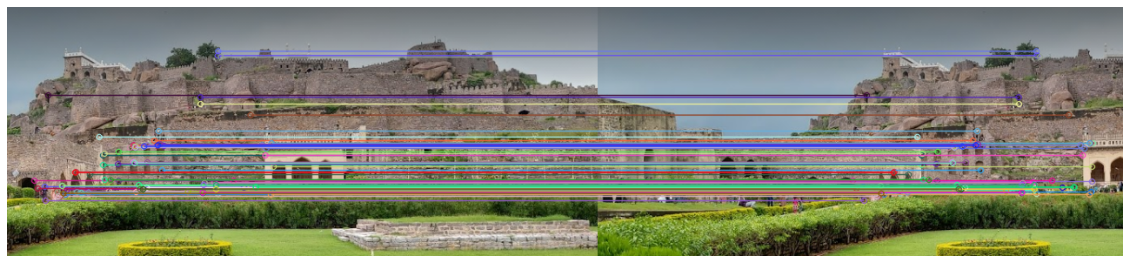

In [6]:
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show(img3)

In [7]:
kpsA = np.float32([kp.pt for kp in kpsA])
kpsB = np.float32([kp.pt for kp in kpsB])
ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)

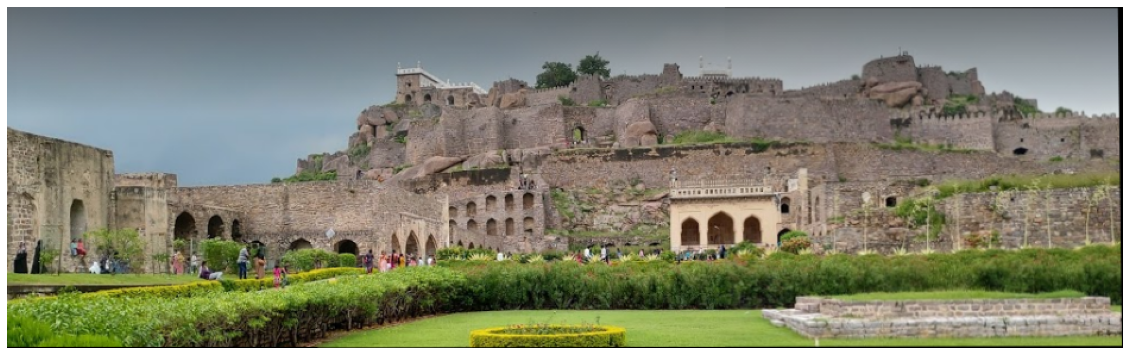

In [8]:
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

_x = np.nonzero(result.sum(0).sum(-1) == 0)[0][0]
_y = np.nonzero(result.sum(1).sum(-1) == 0)[0][0]

show(result[:_y,:_x])